In [1]:
import sys
sys.path.append("./notebooks")  # Adjust the path if model_evaluation.py is elsewhere
from utils.model_evaluation import evaluate_fusion_cnn
import geopandas as gpd

%load_ext autoreload
%autoreload 2

/home/alexisb1/species-dist/ENV/lib/python3.11/site-packages/pyproj/__init__.py:91: UserWarning: Valid PROJ data directory not found. Either set the path using the environmental variable PROJ_DATA (PROJ 9.1+) | PROJ_LIB (PROJ<9.1) or with `pyproj.datadir.set_data_dir`.
  warnings.warn(str(err))


# Model training

In [2]:
from shapely.wkt import loads as wkt_loads
from models.multi_species_fusion_cnn import create_species_configs

def calculate_species_presence_ratio(processed_species_original_locations, species_codes):
    """
    Calculate the ratio of presence for each species in the species_list column.

    Args:
        processed_species_original_locations (GeoDataFrame): DataFrame with a 'species_list' column.
        species_codes (list): List of species codes to check.

    Returns:
        dict: {species_code: presence_ratio}
    """
    total_rows = len(processed_species_original_locations)
    ratios = {}
    for species in species_codes:
        count = processed_species_original_locations['species_list'].apply(lambda x: species in x).sum()
        ratios[species] = count / total_rows
    return ratios

processed_species_original_locations = gpd.read_file("data/saved_df/processed_species_original_locations_point_data.csv")
processed_species_original_locations['geometry'] = processed_species_original_locations['geometry'].apply(wkt_loads)
processed_species_original_locations = gpd.GeoDataFrame(processed_species_original_locations, geometry='geometry', crs="EPSG:6624")
processed_species_original_locations = processed_species_original_locations.to_crs(epsg=4326)


#convert the species_list column which is a list into a list. Now its interpreted as a full string
processed_species_original_locations['species_list'] = processed_species_original_locations['species_list'].apply(lambda x: eval(x) if isinstance(x, str) else x)
#extract all species code from species_list column into a flat list this column is a list of strings
all_species_codes = []
for species_list in processed_species_original_locations['species_list']:
    for species in species_list:
        if species not in all_species_codes:
            all_species_codes.append(species)
species_presence_ratios = calculate_species_presence_ratio(processed_species_original_locations, all_species_codes)

#sort species by presence ratio
sorted_species = sorted(species_presence_ratios.items(), key=lambda x: x[1], reverse=True)

#only keep species with presence ratio > 0.01
filtered_sorted_species = [item for item in sorted_species if item[1] > 0.05]

species_presence_ratios = calculate_species_presence_ratio(processed_species_original_locations, all_species_codes)
#sort species by presence ratio
sorted_species = sorted(species_presence_ratios.items(), key=lambda x: x[1], reverse=True)

#only keep species with presence ratio > 0.01
filtered_sorted_species = [item for item in sorted_species if item[1] > 0.05]

filtered_species_codes = [item[0] for item in filtered_sorted_species]

selected_species = filtered_sorted_species[0:15] + filtered_sorted_species[20:35] + filtered_sorted_species[50:65] + filtered_sorted_species[90:105]
#selected_species = filtered_sorted_species[50:55] + filtered_sorted_species[90:95]

species_names = [item[0] for item in selected_species]
prevalences = [item[1] for item in selected_species]

species_configs = create_species_configs(species_names, prevalences, loss_type="asymmetric", variant='balanced')

In [24]:
from utils.model_evaluation import compute_pos_weight, get_pred_100_band_names
from utils.model_preprocess import create_target_species_df_multiple, get_feature_importance_for_species
from utils.splitting import get_train_val_indices_blocked
from utils.dataset import create_dataset

target_species_arr = species_names

pred_100_band_names = get_pred_100_band_names()

target_df = create_target_species_df_multiple(target_species_arr, processed_species_original_locations)
display(target_df.head())
if target_df.empty:
    print(f"Warning: No data for {target_species_arr}")

print(f"Target DataFrame created with {len(target_df)} records for species: {target_species_arr}")

pos_weights = compute_pos_weight(target_df)
print(f"Computed pos_weight: {pos_weights}")

pred_100_indices = range(len(pred_100_band_names))

# train_indices, val_indices, gdf_with_patches = get_train_val_indices_blocked(
#     processed_species_original_locations, 
#     cell_size=1,
#     n_splits=0.1,
# )

resize_ratio = 0.2


train_dataset = create_dataset(
    npy_files=[
        #{"path": "../scratch/data/npy_data/sentinel2_patches.npy", 'name': 'sentinel2'},
        {"path": "../scratch/data/npy_data/pred100_patches.npy", 'name': 'pred_100'},
    ],  
    target_df=target_df,
    processed_species_original_locations=processed_species_original_locations,
    indices=range(len(target_df)),
    pred_100_indices=pred_100_indices,
    use_transform=True,
    include_coords=True,
    resize_ratio=resize_ratio,
    add_point_infos=True,
    feature_importance_only_tabular=False
)
# val_dataset = create_dataset(
#     npy_files=[
#         #{"path": "../scratch/data/npy_data/sentinel2_patches.npy", 'name': 'sentinel2'},
#         {"path": "../scratch/data/npy_data/pred100_patches.npy", 'name': 'pred_100'},
#     ],      
#     target_df=target_df,
#     processed_species_original_locations=processed_species_original_locations,
#     indices=val_indices,
#     pred_100_indices=pred_100_indices,
#     include_coords=True,
#     resize_ratio=resize_ratio,
#     add_point_infos=True,
#     feature_importance_only_tabular=False
# )

,RES_S,SAB,DIS,PLS,CON,BOP,CLB,MAC,EPN,POS,...,PYR,OSC,PIB,PRV,MEL,COA,CAL,PRS,POP,MON
0,1,1,0,0,1,1,0,1,1,0,...,0,0,0,0,1,0,0,0,0,0
1,1,1,0,1,1,1,1,1,1,1,...,0,0,1,0,0,0,0,0,0,0
2,1,1,0,0,1,1,1,1,0,0,...,0,0,1,0,0,0,0,0,0,0
3,1,1,0,0,1,1,1,1,0,0,...,0,0,1,0,0,0,0,0,0,0
4,1,1,0,0,0,1,1,1,0,0,...,0,0,1,0,0,0,0,0,0,0


Target DataFrame created with 24732 records for species: ['RES_S', 'SAB', 'DIS', 'PLS', 'CON', 'BOP', 'CLB', 'MAC', 'EPN', 'POS', 'CLA_S', 'TRB', 'DRS', 'ARN', 'AME', 'FEU_S', 'CLR', 'CLS', 'ERE', 'VAA', 'KAA', 'SPS', 'EPB', 'LIB', 'SOA', 'LEG', 'ERR', 'SAL', 'COC', 'HYS', 'ERS', 'CLM', 'STR', 'NEM', 'AUR', 'RIG', 'LYL', 'BAT', 'CLT', 'ERP', 'DRD', 'DRP', 'ASM', 'SAP', 'ASA', 'RUC', 'MIN', 'COR', 'SMR', 'SPM', 'PYR', 'OSC', 'PIB', 'PRV', 'MEL', 'COA', 'CAL', 'PRS', 'POP', 'MON']
Computed pos_weight: [0.029170654571166754, 0.2324712214081664, 0.2570266836085098, 0.2610646542931567, 0.5118283513659075, 0.5224376731298723, 0.5998447506303125, 0.6669137965891575, 0.7212053726767894, 0.8686815262554827, 1.0439669421478974, 1.0527888446206402, 1.0682388359248467, 1.0877933479646396, 1.090440368522449, 1.2450980392145559, 1.3066592053709134, 1.3150800336971682, 1.3226897069859853, 1.3778482838175388, 1.6751757706850456, 1.7216903268386465, 1.731912073343939, 1.7993208828502554, 1.831368059528

In [27]:
train_dataset[0]

([tensor([[[0.0000, 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000, 0.0000]],
  
          [[0.4353, 0.4353, 0.4353, 0.4353],
           [0.4353, 0.4353, 0.4353, 0.4353],
           [0.4353, 0.4353, 0.4353, 0.4353],
           [0.4353, 0.4353, 0.4353, 0.4353]],
  
          [[0.8627, 0.8627, 0.8627, 0.8627],
           [0.8627, 0.8627, 0.8627, 0.8627],
           [0.8627, 0.8627, 0.8627, 0.8627],
           [0.8627, 0.8627, 0.8627, 0.8627]],
  
          ...,
  
          [[0.0000, 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000, 0.0000]],
  
          [[0.0000, 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000, 0.0000]],
  
          [[0.0000, 0.0000, 0.0000, 0.0000],
           [0.000

In [23]:
from models.simple_mixture import create_simple_model_and_train


input_dim = train_dataset.effective_shapes
species_prevalences = prevalences
print(f"Train dataset size: {len(train_dataset)}")
print(f"Input dimensions: {input_dim}")
model, shared = create_simple_model_and_train(train_dataset, None, input_dim, species_prevalences, species_names, "Shared only", with_latent=True, loss_fn="dice_bce", use_shared_heads=True, use_independent_heads=False, use_gating=False, use_satelitte=False, use_climate=True)


Train dataset size: 24732
Input dimensions: [{'shape': (67, 20, 20), 'source': 'pred_100'}, {'shape': (67,), 'source': 'point_infos'}, {'shape': (2,), 'source': 'coordinates'}]
Input shapes:
  Branch 0: pred_100 with shape (67, 20, 20)
  Branch 1: point_infos with shape (67,)
  Branch 2: coordinates with shape (2,)
Total features per species head: 320
Setting up DataLoader... Training data has 24732 samples.
No validation dataset provided. Training for full {epochs} epochs. Validation and Early Stopping are DISABLED.

Dice-BCE Loss: dice_weight=0.7, bce_weight=0.3
Pos weights range: [0.03, 15.58]
Starting training...


Training:   0%|                                                                                                                          | 0/193 [00:00<?, ?it/s]

Epoch 1: Loss:  0.6453,  Train F1: 0.5037


Epoch 2: Loss:  0.5703,  Train F1: 0.5725


Epoch 3: Loss:  0.5452,  Train F1: 0.5883


Epoch 4: Loss:  0.5313,  Train F1: 0.5974


Epoch 5: Loss:  0.5224,  Train F1: 0.6039


Epoch 6: Loss:  0.5151,  Train F1: 0.6097
Training finished.
Training on full dataset complete. Model state from final epoch is preserved.
You should use thresholds found during a separate tuning/validation run.


In [24]:
# save model
import torch
torch.save(model.state_dict(), "./saved_models/simple_multi_species_model_2km.pth")

# tresholds = [0.10000000149011612, 0.16530612111091614, 0.26326531171798706, 0.23061224818229675, 0.23061224818229675, 0.3285714089870453, 0.4755101799964905, 0.5244897603988647, 0.3612244725227356, 0.6387754678726196, 0.6224489808082581, 0.5408163070678711, 0.5571428537368774, 0.5734694004058838, 0.5408163070678711, 0.8510203957557678, 0.6714285612106323, 0.6061224341392517, 0.7857142686843872, 0.7530612349510193]
# import numpy as np
# np.save("./saved_models/simple_multi_species_model_1km_thresholds.npy", np.array(tresholds))

# Inference

In [3]:
from shapely.wkt import loads as wkt_loads
processed_species_original_locations = gpd.read_file("data/saved_df/processed_species_original_locations_point_data.csv")
processed_species_original_locations['geometry'] = processed_species_original_locations['geometry'].apply(wkt_loads)
processed_species_original_locations = gpd.GeoDataFrame(processed_species_original_locations, geometry='geometry', crs="EPSG:6624")
processed_species_original_locations = processed_species_original_locations.to_crs(epsg=4326)

In [4]:
import numpy as np

def split_extent(extent, n_parts):
    """
    Split an extent into a grid with equal parts.
    
    extent: [min_x, min_y, max_x, max_y]
    n_parts: total number of parts (must be a perfect square)
    
    Returns:
        A list of extents [min_x, min_y, max_x, max_y] for each cell
    """
    min_x, min_y, max_x, max_y = extent
    n_side = int(np.sqrt(n_parts))
    if n_side * n_side != n_parts:
        raise ValueError("n_parts must be a perfect square (e.g., 4, 9, 16)")
    
    xs = np.linspace(min_x, max_x, n_side + 1)
    ys = np.linspace(min_y, max_y, n_side + 1)
    
    grid_extents = []
    for i in range(n_side):
        for j in range(n_side):
            cell_extent = [
                xs[i], ys[j],     # bottom-left corner
                xs[i+1], ys[j+1]  # top-right corner
            ]
            grid_extents.append(cell_extent)
    
    return grid_extents

extent = processed_species_original_locations.total_bounds  # (minx, miny, maxx, maxy)

parts = 4  # 2x2
cells = split_extent(extent, parts)

for c in cells:
    print(c)


[-79.049562, 45.000945000000016, -71.864493, 48.72007000000002]
[-79.049562, 48.72007000000002, -71.864493, 52.439195000000026]
[-71.864493, 45.000945000000016, -64.679424, 48.72007000000002]
[-71.864493, 48.72007000000002, -64.679424, 52.439195000000026]


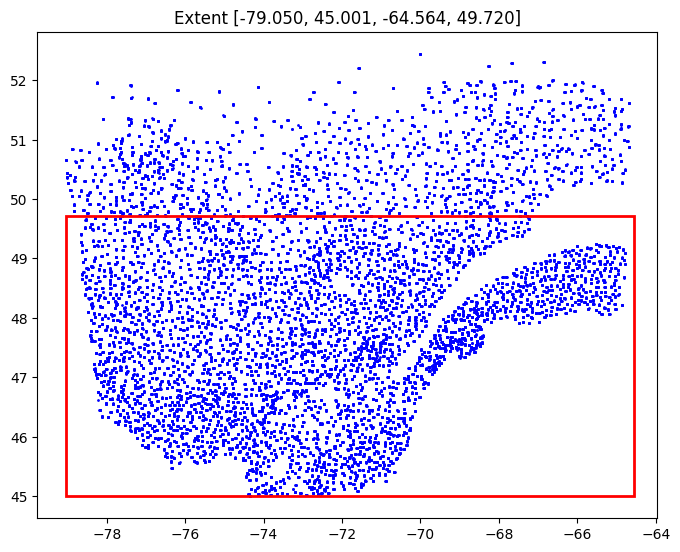

In [15]:
import matplotlib.pyplot as plt

def plot_points_in_cell(cell_idx, points_gdf, cells):
    """
    Plot points_gdf and highlight the cell at cells[cell_idx].
    """
    fig, ax = plt.subplots(figsize=(8, 8))
    points_gdf.plot(ax=ax, color='blue', markersize=1)
    cell = cells[cell_idx]
    rect = plt.Rectangle(
        (cell[0], cell[1]),
        cell[2] - cell[0],
        cell[3] - cell[1],
        linewidth=2, edgecolor='r', facecolor='none'
    )
    ax.add_patch(rect)
    ax.set_title(f"Cell {cell_idx}")
    plt.show()


def plot_points_in_extent(extent, points_gdf, show_points=True, point_color='blue', markersize=1, rect_kwargs=None):
    """
    Plot points_gdf and highlight the given extent.

    extent: sequence-like [minx, miny, maxx, maxy]
    points_gdf: GeoDataFrame of points (assumed to be in the same CRS as extent)
    """
    if rect_kwargs is None:
        rect_kwargs = {'linewidth': 2, 'edgecolor': 'r', 'facecolor': 'none'}

    minx, miny, maxx, maxy = extent
    fig, ax = plt.subplots(figsize=(8, 8))
    if show_points:
        points_gdf.plot(ax=ax, color=point_color, markersize=markersize)
    rect = plt.Rectangle((minx, miny), maxx - minx, maxy - miny, **rect_kwargs)
    ax.add_patch(rect)
    ax.set_title(f"Extent [{minx:.3f}, {miny:.3f}, {maxx:.3f}, {maxy:.3f}]")
    #ax.set_xlim(minx, maxx)
    #ax.set_ylim(miny, maxy)
    plt.show()


# Example usage:
#plot_points_in_cell(2, processed_species_original_locations, cells)
plot_points_in_extent([-79.049562, 45.000945000000016, -64.564493, 49.72007000000002], processed_species_original_locations)

In [5]:
from shapely.geometry import Point
import geopandas as gpd

def grid_centers(extent, cell_km=5):
    """
    Create a grid of fixed-size squares (e.g. 5km x 5km).
    Return a GeoSeries of shapely Point geometries for the centers of each square.
    
    extent: [min_lon, min_lat, max_lon, max_lat]
    cell_km: cell size in km (default 5)
    """
    min_lon, min_lat, max_lon, max_lat = extent
    
    km_per_deg_lat = 111.32
    lat_step = cell_km / km_per_deg_lat
    
    centers = []
    lat = min_lat
    while lat + lat_step <= max_lat:
        km_per_deg_lon = 111.32 * np.cos(np.radians(lat))
        lon_step = cell_km / km_per_deg_lon
        
        lon = min_lon
        while lon + lon_step <= max_lon:
            center_lon = lon + lon_step / 2
            center_lat = lat + lat_step / 2
            centers.append(Point(center_lon, center_lat))
            lon += lon_step
        lat += lat_step
    
    return gpd.GeoSeries(centers, crs="EPSG:4326")


In [6]:
import matplotlib.pyplot as plt
import geopandas as gpd
import rasterio
from shapely.geometry import box

import geopandas as gpd
from shapely.geometry import Point, box
from typing import NamedTuple, Iterator, List, Union
from pyproj import Transformer
from shapely.geometry import box

def get_utm_crs(lon):
    """Dynamically determines the appropriate UTM CRS for a given longitude."""
    utm_zone = int((lon + 180) / 6) + 1
    utm_crs = f"EPSG:326{utm_zone}" if lon >= 0 else f"EPSG:327{utm_zone}"
    return utm_crs

def expand_cell_to_square(points: List[Point], side_length: float, from_crs: str, to_crs: str) -> List[gpd.GeoSeries]:
    """
    Creates square polygons around a list of points in a metric CRS, reprojected to target CRS.
    """
    if points.empty:
        return []

    gdf = gpd.GeoDataFrame(geometry=points, crs=from_crs)
    half_side = side_length / 2

    # Find a metric CRS for buffering - use first point longitude to pick UTM zone
    gdf_wgs84 = gdf.to_crs("EPSG:4326")
    first_lon = gdf_wgs84.geometry.iloc[0].x
    metric_crs = get_utm_crs(first_lon)

    # Reproject to metric CRS for buffering
    gdf_metric = gdf.to_crs(metric_crs)

    # Create square polygons by buffering with cap_style=3 (square)
    gdf_squares = gdf_metric.buffer(half_side, cap_style=3, join_style=2)

    # Reproject squares back to target CRS (usually raster CRS)
    final_gdf = gpd.GeoDataFrame(geometry=gdf_squares, crs=metric_crs).to_crs(to_crs)

    return final_gdf.geometry.tolist()


def generate_expanded_cells(processed_species, side_length_meters, raster_filter=True, qc_bounds_filter=True):
    # Expand H3 cells to square cells
    expanded_cells = expand_cell_to_square(
        points=processed_species.geometry,
        side_length=side_length_meters,
        from_crs=processed_species.crs,
        to_crs='EPSG:6624'
    )
    if 'expanded_cells' in processed_species.columns:
        processed_species = processed_species.drop(columns=['expanded_cells'])
    #merge expanded_cells into processed_species DataFrame as a new column
    processed_species['expanded_cells'] = expanded_cells
    if raster_filter:
        # Filter out cells that are not within the raster bounds
        processed_species = remove_out_of_bounds(processed_species)
        print(f"Number of cells after raster filtering: {len(processed_species)}")
    if qc_bounds_filter:
        # Filter out cells that are not within the Quebec boundaries
        processed_species = filter_with_qc_bounds(processed_species)
        print(f"Number of cells after QC bounds filtering: {len(processed_species)}")
    return processed_species.reset_index(drop=True)

def remove_out_of_bounds(df, raster_path_filter='../scratch/data/data_layers/predictors_100_QC_normalized/alluvion.tif'):
    """
    Remove rows from the DataFrame where the geometry is out of bounds of the raster.
    Prints the number of cells removed.
    """
    with rasterio.open(raster_path_filter) as src:
        raster_bounds_poly = box(*src.bounds)

    mask = gpd.GeoSeries(df['expanded_cells']).within(raster_bounds_poly)
    removed_count = (~mask).sum()
    print(f"Number of cells removed: {removed_count}")

    df = df[mask]
    return df.reset_index(drop=True)

def filter_with_qc_bounds(processed_species):
    gdf = gpd.read_file('../scratch/data/boundaries/lpr_000b16a_e/lpr_000b16a_e.shp')
    quebec_gdf = gdf[gdf['PRENAME'] == 'Quebec']

    # apply crs to the geodataframe
    quebec_gdf = quebec_gdf.to_crs(epsg=6624)
    # Ensure expanded_cells_gdf is a GeoDataFrame and set CRS to match quebec_gdf
    processed_species = processed_species.copy()
    processed_species.to_crs(epsg=6624, inplace=True)
    expanded_cells_gdf = gpd.GeoDataFrame(geometry=processed_species['expanded_cells'], crs=quebec_gdf.crs)
    expanded_cells_gdf['geometry'] = processed_species['geometry'].values
    # Ensure Quebec boundary is simplified (optional but helpful)
    quebec_gdf = quebec_gdf.explode(index_parts=False).reset_index(drop=True)

    # Spatial join using 'within' or 'intersects' (use 'intersects' if you want looser filtering)
    filtered_cells = gpd.sjoin(expanded_cells_gdf, quebec_gdf, predicate="within", how="inner")

    print(f"Number of cells removed: {len(processed_species) - len(filtered_cells)}")
    # Drop join column if not needed
    filtered_cells = filtered_cells.drop(columns=["index_right"])

    #only keep the rows in processed_species_ok that are in filtered_cells
    processed_species_ok = processed_species[processed_species['geometry'].isin(filtered_cells['geometry'])].reset_index(drop=True)

    print(f"bounding box of quebec: {quebec_gdf.total_bounds}")
    print(f"bounding box of expanded cells: {expanded_cells_gdf.total_bounds}")
    # # Plot both on the same matplotlib axis
    # fig, ax = plt.subplots(figsize=(10, 10))

    # # Plot the Quebec boundary
    # quebec_gdf.plot(ax=ax, color='none', edgecolor='black', linewidth=1)

    # # Plot the expanded cells
    # expanded_cells_gdf.plot(ax=ax, color='blue', alpha=0.4)

    # plt.title("Expanded Cells over Quebec")
    # # Remove plt.axis("off") to avoid ValueError: aspect must be finite and positive
    # plt.show()

    return processed_species_ok

In [9]:
#my_extent = cells[0]
my_extent = [-79.049562, 45.000945000000016, -64.564493, 49.72007000000002]  # Use the overall bounding box

cell_size = 1 #km

centers = grid_centers(my_extent, cell_km=cell_size)

gdf_expanded = generate_expanded_cells(gpd.GeoDataFrame(geometry=centers, crs="EPSG:4326"), cell_size * 1000) #generate 1km cells for the map
print(f"Generated {len(centers)} cells")

gdf = gpd.read_file('../scratch/data/boundaries/lpr_000b16a_e/lpr_000b16a_e.shp')
quebec_gdf = gdf[gdf['PRENAME'] == 'Quebec']
boundaries = quebec_gdf.to_crs(epsg=4326)

Number of cells removed: 37311
Number of cells after raster filtering: 535766
Number of cells removed: 175101
bounding box of quebec: [-831089.93304842  117211.38066121  783876.54176348 2103332.26373041]
bounding box of expanded cells: [-747076.84579874  118124.8698141   275782.24988065  689885.1563236 ]
Number of cells after QC bounds filtering: 360665
Generated 573077 cells


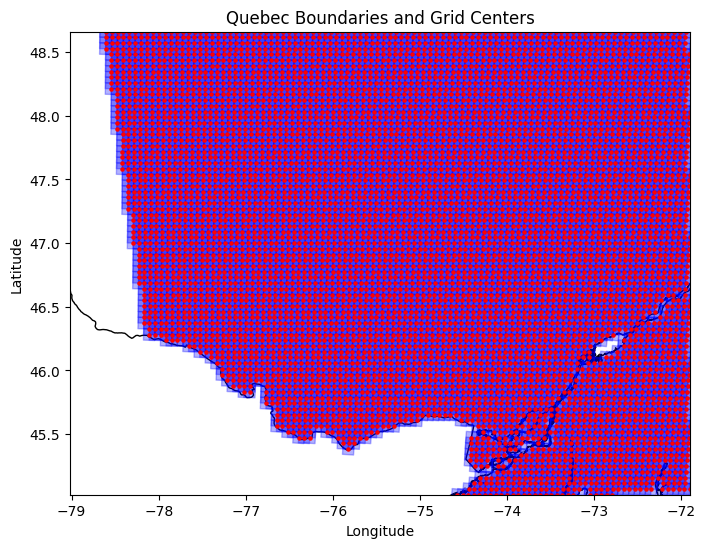

In [13]:
fig, ax = plt.subplots(figsize=(8, 8))

# Quebec boundaries (optional)
boundaries.plot(ax=ax, color='none', edgecolor='black', linewidth=1)

# Expanded cells (polygons)
gpd.GeoSeries(gdf_expanded['expanded_cells'], crs="EPSG:6624")\
    .to_crs(epsg=4326)\
    .plot(ax=ax, facecolor='blue', edgecolor='blue', alpha=0.3)

# Original center points
gpd.GeoSeries(gdf_expanded['geometry'], crs="EPSG:6624")\
    .to_crs(epsg=4326)\
    .plot(ax=ax, color='red', markersize=5)

# Zoom to centers extent
minx, miny, maxx, maxy = gpd.GeoDataFrame(geometry=centers, crs="EPSG:4326").total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

plt.title("Quebec Boundaries and Grid Centers")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


In [10]:
import os
from matplotlib.figure import Figure
import rasterio
import time
import re
from typing import Any, Sequence, cast

from rasterio.windows import from_bounds
from rasterio.mask import mask
from shapely.geometry import mapping
from pyproj import CRS
from rasterio.features import rasterize
from torchgeo.datasets import RasterDataset

import torch
from torchgeo.samplers import GeoSampler
from torchgeo.datasets.utils import BoundingBox
from typing import Iterator
import geopandas as gpd
from pyproj import CRS
import numpy as np

def get_raster_as_bands(directory):
    #only keep the file name without the directory
    pred100_raster_files = fetch_raster_files_from_directories([directory])
    pred100_raster_names = [os.path.basename(f) for f in pred100_raster_files]
    #remove file extension from paths
    pred100_raster_names = [os.path.splitext(f)[0] for f in pred100_raster_names]   
    pred100_raster_names.sort()
    #transform into a tuple
    pred100_raster_names = tuple(pred100_raster_names)
    print(f"Pred100 raster names: {pred100_raster_names}")
    return pred100_raster_names

class IndependentBandsDataset(RasterDataset):
    filename_glob = "*.tif"          # Adjust this if needed
    #crs = "EPSG:6624"                # Your CRS
    resolution = (100, 100)                 # Your resolution, if you want to resample
    separate_files = False           # Set True if each band is a separate file
    is_image = True               # Set False if not image data
    filename_regex = r"^(?P<band>.+)\.tif$"  # Extract band name from filename (without extension)

    def __init__(self, paths: str, all_bands: list[str], transforms=None, separate_files=False, resolution=(100, 100)):
        
        super().__init__(paths, transforms=transforms)
        self.separate_files = separate_files
        self.all_bands = all_bands
        self.bands = all_bands
        self.resolution = resolution
        self.crs = "EPSG:6624"  # Set your CRS here
    

    def plot(self, samples, bands: list[str] | None = None, 
         show_titles: bool = True, suptitle: str | None = None) -> Figure:
        """
        Plot one or more samples with the selected bands.

        Args:
            samples: dict (single sample) or list of dicts
            bands: list of band names to visualize
            show_titles: show subplot titles
            suptitle: optional figure title
        """
        # Handle single sample vs multiple
        if isinstance(samples, dict):
            samples = [samples]

        n_samples = len(samples)
        image = samples[0]["image"]

        # Resolve band indices
        if bands is None:
            band_indices = list(range(image.shape[0]))
            bands = self.all_bands
        else:
            band_indices = []
            for band in bands:
                if band in self.all_bands:
                    idx = self.all_bands.index(band)
                    band_indices.append(idx)
                else:
                    raise ValueError(f"Band {band} not in dataset bands: {self.all_bands}")

        n_bands = len(band_indices)

        # Grid size = rows = samples, cols = bands
        fig, axs = plt.subplots(
            nrows=n_samples, ncols=n_bands, figsize=(4 * n_bands, 4 * n_samples)
        )

        if n_samples == 1 or n_bands == 1:
            axs = np.array(axs).reshape(n_samples, n_bands)

        for row, sample in enumerate(samples):
            image = sample["image"]
            for col, (band_index, band_name) in enumerate(zip(band_indices, bands)):
                band_data = image[band_index].numpy()
                ax = axs[row, col]
                im = ax.imshow(band_data, cmap="viridis")
                ax.axis("off")
                if show_titles:
                    ax.set_title(f"{band_name}" if n_samples == 1 else f"S{row} - {band_name}")

        fig.colorbar(im, ax=axs.ravel().tolist(), fraction=0.046, pad=0.04)

        if suptitle is not None:
            plt.suptitle(suptitle)

        plt.tight_layout()
        plt.close(fig)
        return fig




class PointGeoSampler(GeoSampler):
    def __init__(self, dataset, locations: gpd.GeoSeries, side_length_meters: float):
        """
        dataset: raster dataset with .crs attribute
        locations: GeoSeries with points
        side_length_meters: patch side length in meters
        """
        self.dataset = dataset
        self.dataset_crs = dataset.crs
        self.side_length_meters = side_length_meters
        self.locations = locations

        # Reproject points to raster CRS if needed
        if locations.crs != self.dataset_crs:
            self.points_in_dataset_crs = locations.to_crs(self.dataset_crs)
        else:
            self.points_in_dataset_crs = locations

        # Pre-compute all bounding boxes
        self._precompute_bboxes()
        
        # Time bounds
        if hasattr(dataset.bounds, 'mint'):
            self.mint = dataset.bounds.mint
            self.maxt = dataset.bounds.maxt
        else:
            self.mint = 0
            self.maxt = 0

    def _precompute_bboxes(self):
        """Pre-compute all bounding boxes for maximum speed"""
        points = self.points_in_dataset_crs.geometry
        half_side = self.side_length_meters / 2
        
        if self.dataset_crs.is_geographic:
            # Extract coordinates as arrays
            lons = np.array([p.x for p in points])
            lats = np.array([p.y for p in points])
            
            # Vectorized degree conversion
            meters_per_degree_lat = 111_320
            deg_lats = half_side / meters_per_degree_lat
            
            cos_lats = np.cos(np.radians(lats))
            deg_lons = half_side / (meters_per_degree_lat * cos_lats)
            
            # Compute all bounding boxes at once
            minxs = lons - deg_lons
            maxxs = lons + deg_lons
            minys = lats - deg_lats
            maxys = lats + deg_lats
            
        else:
            # Projected CRS
            xs = np.array([p.x for p in points])
            ys = np.array([p.y for p in points])
            
            minxs = xs - half_side
            maxxs = xs + half_side
            minys = ys - half_side
            maxys = ys + half_side
        
        # Store pre-computed bounding boxes
        self.bboxes = list(zip(minxs, maxxs, minys, maxys))

    def __iter__(self) -> Iterator[BoundingBox]:
        for minx, maxx, miny, maxy in self.bboxes:
            yield BoundingBox(minx, maxx, miny, maxy, self.mint, self.maxt)

    def get_all_queries(self):
        return list(self.__iter__())

    def __len__(self) -> int:
        return len(self.bboxes)
    
def fetch_raster_files_from_directories(directories, include_files=None):
    """
    Fetch raster files from specified directories.
    
    Parameters:
    - directories: List of directories to search for raster files.
    - include_files: Optional list of file names to include.
    
    Returns:
    - List of file paths for raster files.
    """
    raster_files = []
    for directory in directories:
        for root, _, files in os.walk(directory):
            for file in files:
                if include_files is not None:
                    if file.endswith('.tif') and any(include in file for include in include_files):
                        raster_files.append(os.path.join(root, file))
                else:
                    if file.endswith('.tif'):
                        raster_files.append(os.path.join(root, file))
    return raster_files

def get_raster_as_bands(directory):
    #only keep the file name without the directory
    pred100_raster_files = fetch_raster_files_from_directories([directory])
    pred100_raster_names = [os.path.basename(f) for f in pred100_raster_files]
    #remove file extension from paths
    pred100_raster_names = [os.path.splitext(f)[0] for f in pred100_raster_names]   
    pred100_raster_names.sort()
    #transform into a tuple
    pred100_raster_names = tuple(pred100_raster_names)
    print(f"Pred100 raster names: {pred100_raster_names}")
    return pred100_raster_names

In [ ]:
import os
import numpy as np
import rasterio
import torch
from torch.utils.data import Dataset
from torchgeo.datasets import RasterDataset
from torchgeo.datasets.utils import BoundingBox
from typing import Any, Optional, Dict # Make sure to import Any, Optional, Dict
from pyproj import CRS, Transformer # <-- Import pyproj

class InMemoryBandsDataset(RasterDataset):
    def __init__(
        self, 
        paths: str, 
        all_bands: list[str], 
        transforms=None, 
        normalization_bounds: list[float] = None
    ):
        """
        Initializes the dataset by loading all specified raster bands into memory.
        
        Args:
            paths (str): Path to the directory containing .tif files.
            all_bands (list[str]): List of band names. The filenames in `paths`
                                   are expected to correspond to these bands.
            transforms (callable, optional): A function/transform that takes a sample
                                             and returns a transformed version.
            normalization_bounds (list[number], optinal): extent bounds for normalization
        """
        super().__init__(paths, transforms=transforms)
        self.all_bands = all_bands
        self.bands = all_bands # This line is important for RasterDataset

        self._crs = None  # private storage for CRS
        self.transform = None # private storage for affine transform
        self._bounds = None # private storage for bounds

        # --- Load all rasters into memory ---
        # We assume the filenames match the band names provided
        raster_files = []
        for band_name in self.all_bands:
            # Look for a file that contains the band name
            found = False
            for f in os.listdir(paths):
                # Check if file name starts with band name and ends with .tif
                if f.startswith(band_name) and f.endswith(".tif"):
                    raster_files.append(os.path.join(paths, f))
                    found = True
                    break
            if not found:
                print(f"Warning: No .tif file found for band: {band_name}")

        
        arrays = []
        print(f"Loading {len(raster_files)} rasters into memory...")
        for f in raster_files:
            with rasterio.open(f) as src:
                arrays.append(src.read(1))  # read first (and only) band
                if self._crs is None:
                    # Store metadata from the first file
                    self._crs = src.crs
                    self.transform = src.transform
                    self._bounds = BoundingBox(*src.bounds, mint=0, maxt=0)
                    self.height = src.height
                    self.width = src.width
                    print(f"Dataset CRS set to: {self._crs}")
                    print(f"Dataset Dimensions (H, W): ({self.height}, {self.width})")
                    
                    # --- NEW: Set up CRS transformation and normalization bounds ---
                    self.target_crs = CRS.from_epsg(4326)
                    # Create a transformer, ensuring (lon, lat) output
                    self.transformer = Transformer.from_crs(self._crs, self.target_crs, always_xy=True)
                    if normalization_bounds:
                        print("Using provided normalization bounds.")
                        self.min_lon = normalization_bounds[0]
                        self.max_lon = normalization_bounds[2]
                        self.min_lat = normalization_bounds[1]
                        self.max_lat = normalization_bounds[3]
                    else:
                        print("No extent provided. Cant compute normalization bounds.")
                    print(f"Using EPSG:4326 Lon range for normalization: ({self.min_lon}, {self.max_lon})")
                    print(f"Using EPSG:4326 Lat range for normalization: ({self.min_lat}, {self.max_lat})")
                    # --- END NEW ---

        # Shape: (bands, H, W)
        self.data = np.stack(arrays, axis=0).astype(np.float32)
        print(f"In-memory data shape: {self.data.shape}")

    @property
    def bounds(self):
        """Returns the geographic bounds of the dataset."""
        return self._bounds

    @property
    def crs(self):
        """Returns the coordinate reference system of the dataset."""
        return self._crs

    def __getitem__(self, query: BoundingBox) -> dict[str, Any]:
        """
        Retrieve image/mask and metadata indexed by a geographic query.
        
        Also retrieves the geospatial coordinates and data values at the
        center of the query.
        """
        # Use the R-tree index like the original
        # This check is still useful to ensure the query is valid
        hits = self.index.intersection(tuple(query), objects=True)
        if not hits:
            raise IndexError(
                f"query: {query} not found in index with bounds: {self.bounds}"
            )

        # In-memory version: no file reading, just slice self.data
        # Convert query bounds to pixel indices
        col_start_px, row_start_px = ~self.transform * (query.minx, query.maxy)
        col_stop_px,  row_stop_px  = ~self.transform * (query.maxx, query.miny)

        # Use round() for all indices to get the *nearest* pixel
        row_start = max(0, int(np.round(row_start_px)))
        row_stop  = max(0, int(np.round(row_stop_px)))
        col_start = max(0, int(np.round(col_start_px)))
        col_stop  = max(0, int(np.round(col_stop_px)))

        # Clip to dataset dimensions
        row_start_c = min(row_start, self.height)
        row_stop_c  = min(row_stop, self.height)
        col_start_c = min(col_start, self.width)
        col_stop_c  = min(col_stop, self.width)

        # Slice the in-memory array to get the patch
        patch_data = self.data[:, row_start_c:row_stop_c, col_start_c:col_stop_c]
        patch_data_tensor = torch.from_numpy(patch_data).to(self.dtype)

        # --- MODIFIED LOGIC: Get center point info, transform, and normalize ---
        
        # 1. Calculate geospatial center of the query in *original CRS*
        center_x = (query.minx + query.maxx) / 2.0
        center_y = (query.miny + query.maxy) / 2.0
        
        # 2. Transform center to EPSG:4326 (lon, lat)
        # self.transformer was set to always_xy=True, so output is (lon, lat)
        lon, lat = self.transformer.transform(center_x, center_y)

        # 3. Normalize coordinates to [-1, 1] range using dataset-wide bounds
        # Handle division by zero if max == min (e.g., a single point dataset)
        lon_range = self.max_lon - self.min_lon
        lat_range = self.max_lat - self.min_lat
        
        normalized_lon = 0.0 # Default if range is zero
        if lon_range > 1e-9: # Avoid division by zero
            normalized_lon = 2 * (lon - self.min_lon) / lon_range - 1
            
        normalized_lat = 0.0 # Default if range is zero
        if lat_range > 1e-9: # Avoid division by zero
            normalized_lat = 2 * (lat - self.min_lat) / lat_range - 1
        
        # This is the 'coordinates' value, stacked as (lat, lon) per your example
        coordinates_tensor = torch.tensor(
            [normalized_lat, normalized_lon], 
            dtype=torch.float32
        )

        # 4. Convert geospatial center to *pixel* coordinates for sampling
        col_c_pixel, row_c_pixel = ~self.transform * (center_x, center_y)
        row_c_pixel = int(round(row_c_pixel))
        col_c_pixel = int(round(col_c_pixel))

        # 5. Clip pixel coordinates to be safely within array bounds
        row_c_clipped = max(0, min(row_c_pixel, self.height - 1))
        col_c_clipped = max(0, min(col_c_pixel, self.width - 1))

        # 6. Sample the in-memory data at the center pixel
        # self.data is (bands, H, W), so point_infos will be a (bands,) array
        point_infos = self.data[:, row_c_clipped, col_c_clipped]
        
        # This is the 'point_infos' value
        point_infos_tensor = torch.from_numpy(point_infos).to(self.dtype)
        
        # --- END MODIFIED LOGIC ---

        # Build sample dict
        sample = {
            #"crs": self.crs, 
            #"bounds": query,
            "coordinates": coordinates_tensor, # MODIFIED: Normalized (lat, lon) tensor
            "point_infos": point_infos_tensor  # Data values at center
        }
        
        if self.is_image:
            sample["image"] = patch_data_tensor
        else:
            sample["mask"] = patch_data_tensor.squeeze(0)

        # Apply transforms if any (transforms will now see all keys)
        if self.transforms is not None:
            sample = self.transforms(sample)

        return sample

    def __len__(self):
        """
        Returns the number of items in the dataset.
        
        For an in-memory dataset, this is often just 1, as it's
        sampled from, not iterated over in a traditional sense.
        Or, it could represent the total number of pixels, etc.
        Keeping it simple for now.
        """
        return 1

    
    def plot(
        self,
        sample: dict,
        bands: list[str] | None = None,
        show_titles: bool = True,
        suptitle: str | None = None,
    ) -> plt.Figure:
        """
        Plot a sample with the selected bands.

        Args:
            sample: dict returned by __getitem__
            bands: list of band names to visualize
            show_titles: whether to display band titles
            suptitle: optional figure title
        """
        image = sample["image"]  # tensor of shape (bands, H, W)
        image_np = image.numpy()

        # Resolve band indices
        if bands is None:
            band_indices = list(range(image_np.shape[0]))
            bands = self.all_bands
        else:
            band_indices = [self.all_bands.index(b) for b in bands]

        n_bands = len(band_indices)

        # Create figure
        fig, axs = plt.subplots(1, n_bands, figsize=(4 * n_bands, 4))
        if n_bands == 1:
            axs = [axs]

        for i, idx in enumerate(band_indices):
            axs[i].imshow(image_np[idx], cmap="viridis")
            axs[i].axis("off")
            if show_titles:
                axs[i].set_title(bands[i])

        if suptitle is not None:
            plt.suptitle(suptitle)

        plt.tight_layout()
        plt.close(fig)  # close to avoid automatic display in notebooks
        return fig


In [33]:
pred100_raster_names = get_raster_as_bands("../scratch/data/data_layers/predictors_100_QC_normalized")
# pred_100_dataset = IndependentBandsDataset(paths= "../scratch/data/data_layers/predictors_100_QC_normalized",
#                                          all_bands=pred100_raster_names,
#                                          separate_files=True)
pred_100_dataset = InMemoryBandsDataset(paths= "../scratch/data/data_layers/predictors_100_QC_normalized",
                                            all_bands=pred100_raster_names)
sampler_cell_size = 2 #km
point_sampler = PointGeoSampler(
    dataset=pred_100_dataset,
    locations=gdf_expanded['geometry'],
    side_length_meters=sampler_cell_size * 1000
)
queries = point_sampler.get_all_queries()

Pred100 raster names: ('alluvion', 'annual_precipitation_amount', 'annual_range_of_air_temperature', 'barren', 'bulk_density', 'clay', 'combined_mask', 'coniferous', 'cropland', 'deciduous', 'depot', 'distance_to_roads', 'eau_peu_profonde', 'elevation', 'eolien', 'geomflat', 'geomfootslope', 'glaciaire', 'glaciolacustre', 'human_modification', 'indifferencie', 'isothermality', 'lacustre', 'lai', 'marais', 'marecage', 'mean_annual_air_temperature', 'mean_daily_maximum_air_temperature_of_the_warmest_month', 'mean_daily_mean_air_temperatures_of_the_coldest_quarter', 'mean_daily_mean_air_temperatures_of_the_driest_quarter', 'mean_daily_mean_air_temperatures_of_the_warmest_quarter', 'mean_daily_mean_air_temperatures_of_the_wettest_quarter', 'mean_daily_minimum_air_temperature_of_the_coldest_month', 'mean_diurnal_air_temperature_range', 'mean_monthly_precipitation_amount_of_the_coldest_quarter', 'mean_monthly_precipitation_amount_of_the_driest_quarter', 'mean_monthly_precipitation_amount_of_

In [16]:
samples = [pred_100_dataset[q] for q in queries[10:15]]

# pred_100_dataset.plot(samples, bands=['elevation', 'annual_precipitation_amount', 'annual_range_of_air_temperature'], suptitle="Sample Patch from Pred100 Dataset")

In [34]:
from torch.utils.data import DataLoader
from torchgeo.datasets import stack_samples


# torch.cuda.empty_cache()
# import gc; gc.collect()

# del map_loader
map_loader = DataLoader(
    dataset=pred_100_dataset,
    batch_size=32,
    sampler=point_sampler,
    collate_fn=stack_samples,
    num_workers=0,
    pin_memory=True,
    drop_last=True,
    persistent_workers=False
)


In [57]:
#load one batch 
batch = next(iter(map_loader))
print(f"Batch image shape: {batch['image'].shape}") 


Batch image shape: torch.Size([32, 67, 25, 25])


In [14]:
from models.simple_mixture import HybridMultiSpeciesModel

# Recreate the model architecture
input_dims = [{'shape': (67, 20, 20), 'source': 'pred_100'}, {'shape': (67,), 'source': 'point_infos'}, {'shape': (2,), 'source': 'coordinates'}]
model = HybridMultiSpeciesModel(input_dims, len(species_names), use_latent=True, use_shared_heads=True, use_independent_heads=False, use_gating=False, use_satelitte=False, use_climate=True).to("cuda")
model.load_state_dict(torch.load("./saved_models/simple_multi_species_model_2km.pth"))

model.eval()  # set to inference mode

Total features per species head: 320


HybridMultiSpeciesModel(
  (clim_branch): FlexibleCNNBranchSpatial(
    (conv_layers): Sequential(
      (0): Conv2d(67, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.1)
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): LeakyReLU(negative_slope=0.1)
      (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): LeakyReLU(negative_slope=0.1)
    )
  )
  (point_branch): Sequential(
    (0): Linear(in_features=67, out_features=128, bias=True

In [14]:
def flush_gpu():
    import torch, gc
    gc.collect()
    torch.cuda.empty_cache()
    for var in ['model', 'optimizer', 'criterion']:
        if var in globals():
            del globals()[var]
flush_gpu()

In [31]:
import torch
from torch.utils.data import DataLoader
from torchgeo.datasets.utils import stack_samples
from tqdm import tqdm
import pandas as pd


# ---- 3. Run inference with tqdm ----
all_preds = []
all_coords = []

device = "cuda" if torch.cuda.is_available() else "cpu"
sample_idx = 0  # Track global sample index across batches

with torch.no_grad():
    for idx, batch in enumerate(tqdm(map_loader, desc="Running inference")):
        # Move data to GPU/CPU
        #print(f"Processing batch {idx+1} with batch size {batch['image'].shape[0]}")
        images = batch['image'].to(device)
        coords = batch['coordinates'].to(device)
        point_infos = batch['point_infos'].to(device)
        batch_size = images.shape[0]
        # Forward pass
        
        model_inputs = []
        if model.sat_branch is not None:
            model_inputs.append(sat_data)
            
        if model.clim_branch is not None:
            model_inputs.append(images)
            
        if model.point_branch is not None:
            model_inputs.append(point_infos)
        
        #print(f"input shape: {inputs.shape}")
        final_logits, shared_logits, specific_logits, latent, gates = model(model_inputs, coords)
        probs = torch.sigmoid(final_logits)
        
        # Save results
        all_preds.append(probs.cpu())
        
        # Get coordinates for ALL samples in this batch
        for i in range(batch_size):
            geom = gdf_expanded['geometry'].iloc[sample_idx + i]
            all_coords.append(geom)
        
        sample_idx += batch_size

print("✅ Inference complete")

# ---- 4. Concatenate results ----
all_preds = torch.cat(all_preds, dim=0).numpy()

print(f"Predictions shape: {all_preds.shape}")
print(f"Coordinates collected: {len(all_coords)}")

# Create GeoDataFrame with the processed samples
results_gdf = gpd.GeoDataFrame(
    geometry=all_coords,
    crs="EPSG:4326"
)

# Add predictions as columns
for i in range(all_preds.shape[1]):
    results_gdf[f"species_{i}_prob"] = all_preds[:, i]

print(f"✅ Results DataFrame created with {len(results_gdf)} samples")

Running inference:   0%|                                                                                                                       | 0/11270 [00:00<?, ?it/s]

Running inference:   0%|                                                                                                               | 8/11270 [00:00<12:30, 15.00it/s]


RuntimeError: stack expects each tensor to be equal size, but got [67, 20, 20] at entry 0 and [67, 19, 20] at entry 5

In [52]:
#save results_gdf to a csv file
results_gdf.to_file("predicted_species_distributions_5km.geojson", driver="GeoJSON")

In [67]:
#load species names from csv file
species_info_df = pd.read_csv("./data/saved_df/species_names.csv")

In [90]:
species_info_df[species_info_df['Code'] == "DIS"]

,Code,Nom français,Nom latin
148,DIS,NaN,Dicranum Hedw.


In [68]:
species_info_df

,Code,Nom français,Nom latin
0,ACM,Achillée millefeuille,Achillea millefolium Linnaeus
1,ACP,Actée à gros pédicelles,Actaea pachypoda Elliott
2,ACR,Actée rouge,Actaea rubra (Aiton) Willdenow
3,ACS,Actée,Actaea Linnaeus
4,ADP,Adiante du canada,Adiantum pedatum Linnaeus
...,...,...,...
531,VIS,Violette,Viola Linnaeus
532,VIT,Viorne trilobée,Viburnum opulus var. americanum Aiton
533,VIV,Violette pubescente,Viola pubescens Aiton
534,WAF,Waldsteinie faux-fraisier,Geum fragarioides (Michaux) Smedmark


In [77]:
#load results
species_names = [
 'RES_S',
 'SAB',
 'DIS',
 'PLS',
 'CON',
 'FEU_S',
 'CLR',
 'CLS',
 'ERE',
 'VAA',
 'ERS',
 'CLM',
 'STR',
 'NEM',
 'AUR',
 'RUC',
 'MIN',
 'COR',
 'SMR',
 'SPM']
results_df = gpd.read_file("predicted_species_distributions_10km.geojson")
# If you want to ensure the CRS is set to EPSG:6624, use set_crs with allow_override
results_gdf = results_df.set_crs("EPSG:6624", allow_override=True)
results_gdf.to_crs(epsg=4326, inplace=True)

#put the right species names as columns
for i, species in enumerate(species_names):
    results_gdf = results_gdf.rename(columns={f"species_{i}_prob": species})

In [96]:
res_gdf = gpd.read_file("predicted_species_distributions_10km.geojson")
print(res_gdf.columns)

Index(['species_0_prob', 'species_1_prob', 'species_2_prob', 'species_3_prob',
       'species_4_prob', 'species_5_prob', 'species_6_prob', 'species_7_prob',
       'species_8_prob', 'species_9_prob', 'species_10_prob',
       'species_11_prob', 'species_12_prob', 'species_13_prob',
       'species_14_prob', 'species_15_prob', 'species_16_prob',
       'species_17_prob', 'species_18_prob', 'species_19_prob', 'geometry'],
      dtype='object')


['Résineux (SAB, EPB, PIB, PIR, PRU,THO, EPN,PIG, MEL et EPR', 'Sapin baumier', 'DIS', 'Hypne de schreber', 'Quatre-temps', 'Feuillus (ERR, BOJ, FEU_R et FEU_H)', 'Cladonie rangifère', 'Cladonie', 'Érable à épis', 'Bleuet à feuilles étroites', 'Érable à sucre', 'Cladonie lisse', 'Streptope rose', 'Némopanthe mucroné', 'Aulne rugueux', 'Chicouté', 'Mitrelle nue', 'Cornouiller stolonifère', 'Smilacine à grappes', 'SPM']


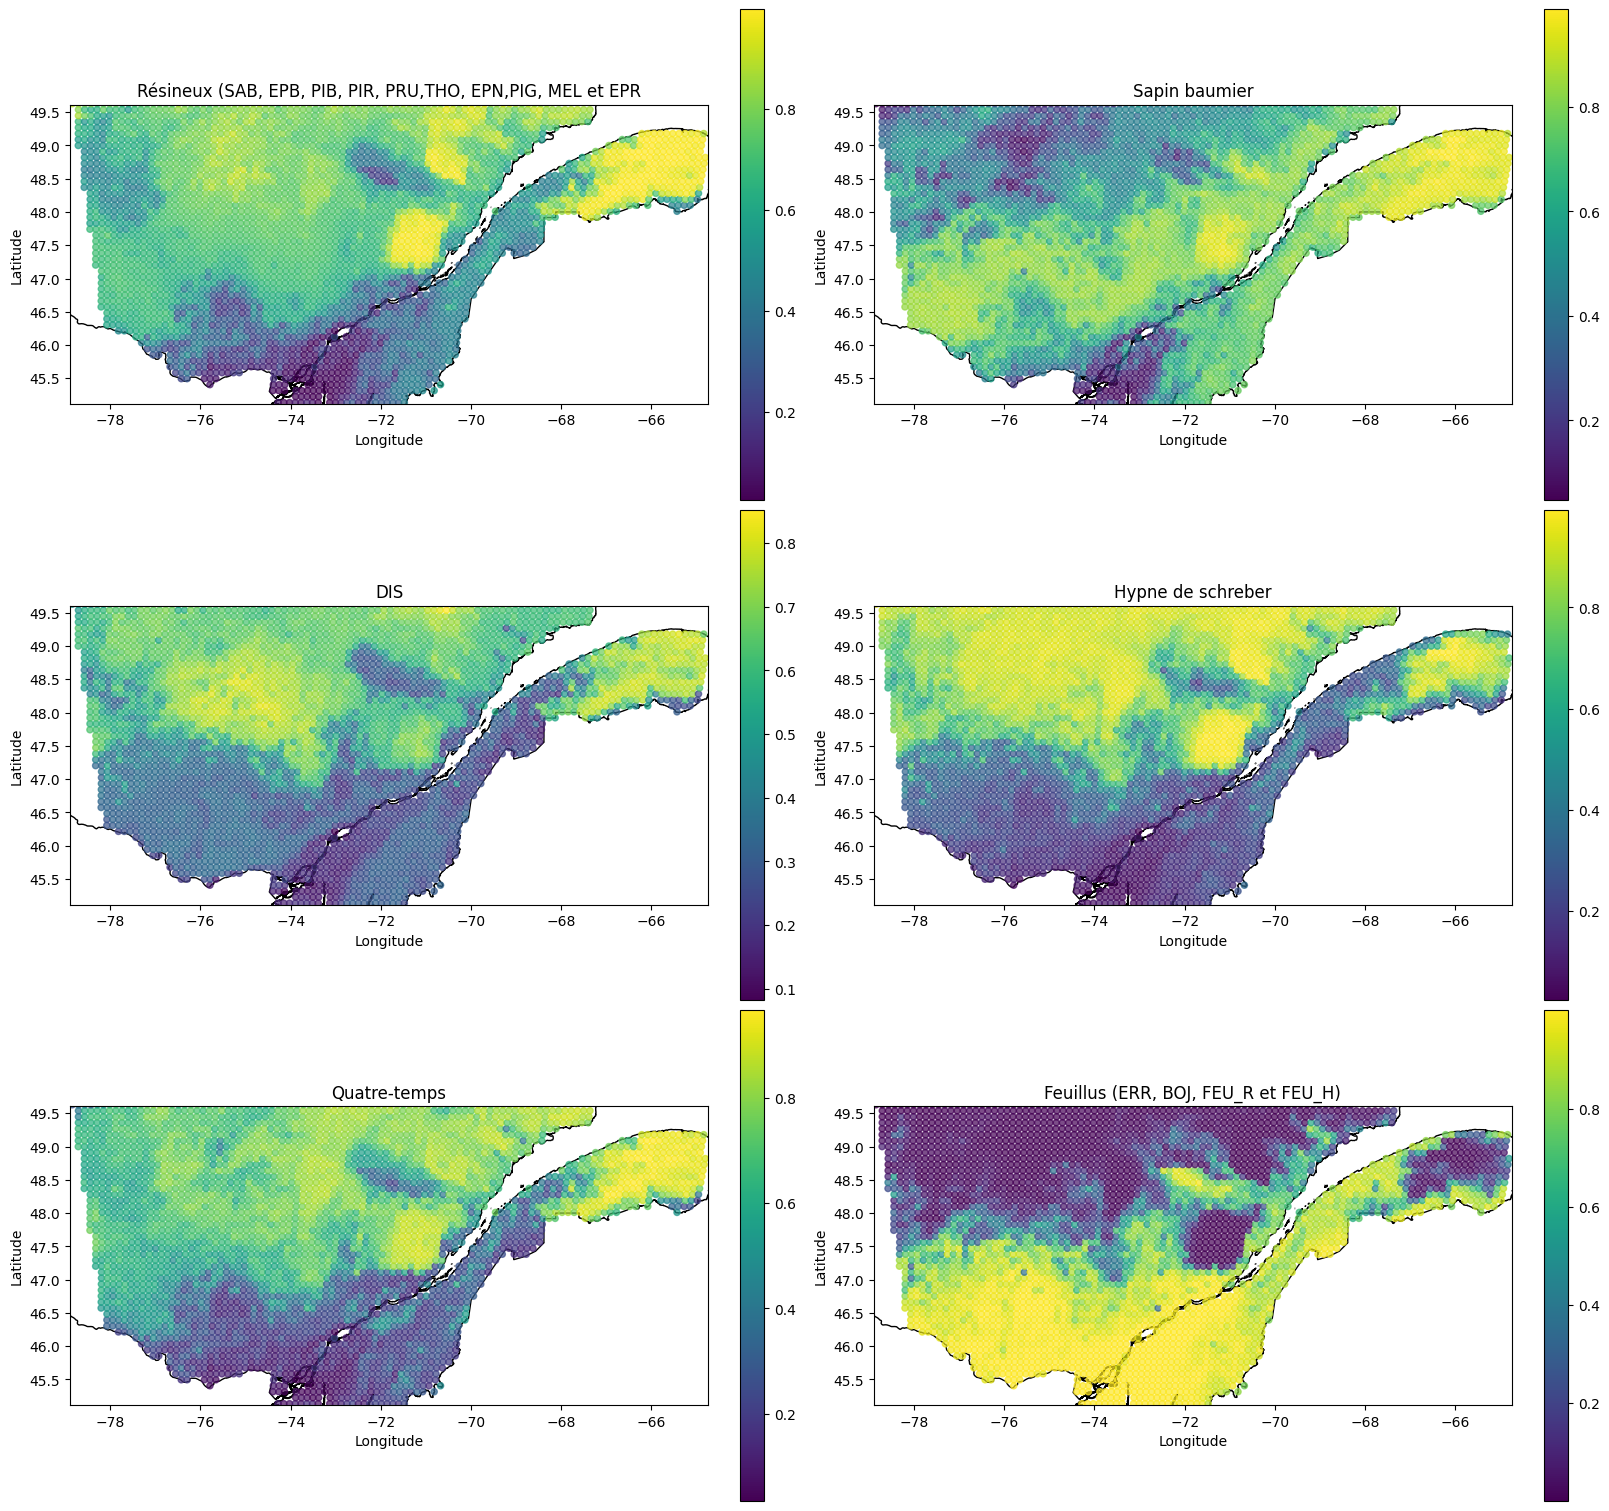

In [93]:
import numpy as _np
import geopandas as _gpd
import matplotlib.pyplot as _plt

def plot_species_grid(nb_species, species_list=None, results=results_gdf, boundaries_gdf=boundaries, centers_gs=centers, cmap="viridis", markersize=2):
    """
    Plot up to nb_species in a grid with at most 2 species per row.
    Uses existing variables: results_gdf, boundaries, centers by default.
    Titles are taken from species_list (if provided) — columns are always the species codes in `species_names`.
    Returns the matplotlib Figure.
    """
    if species_list is None:
        # build title list from species_info_df using species_names
        titles = []
        for code in species_names:
            full = species_info_df[species_info_df['Code'] == code]['Nom français'].values
            titles.append(full[0] if len(full) > 0 else code)
    else:
        titles = species_list

    nb = min(int(nb_species), len(titles), len(species_names))
    if nb <= 0:
        raise ValueError("nb_species must be >= 1")

    cols = min(2, nb)
    rows = int(_np.ceil(nb / cols))

    fig, axes = _plt.subplots(rows, cols, figsize=(cols * 8, rows * 5), constrained_layout=True)
    axes = _np.atleast_1d(axes).ravel()

    # compute zoom bounds from centers
    bounds = _gpd.GeoDataFrame(geometry=centers_gs, crs="EPSG:4326").total_bounds
    minx, miny, maxx, maxy = bounds

    for i in range(nb):
        ax = axes[i]
        code = species_names[i]      # column name in results_gdf
        title = titles[i]           # human-readable title from species_list

        # plot boundary and species probabilities
        boundaries_gdf.plot(ax=ax, color='none', edgecolor='black', linewidth=1)
        results.plot(column=code, cmap=cmap, legend=True, markersize=markersize, ax=ax, alpha=0.7)

        ax.set_xlim(minx, maxx)
        ax.set_ylim(miny, maxy)
        ax.set_title(title)
        ax.set_xlabel("Longitude")
        ax.set_ylabel("Latitude")

    # turn off any unused subplots
    for j in range(nb, rows * cols):
        axes[j].axis("off")

    

#find full name of species in species_info_df
species_list = []
for sp_code in species_names:
    names = species_info_df.loc[species_info_df['Code'] == sp_code, 'Nom français']
    if not names.empty and pd.notna(names.values[0]):
        species_list.append(names.values[0])
    else:
        species_list.append(sp_code)
print(species_list)
plot_species_grid(6, species_list=species_list, markersize=20)

In [117]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_species_multi_res_grid_from_gdfs(res_gdfs, species_codes, n_species_show, species_info_df,
                                          boundaries_gdf, centers_gs,
                                          resolutions, cmap="viridis", markersizes=None):
    """
    Plot multiple species probabilities for different resolutions.

    Parameters:
    - res_gdfs: dict of {resolution: GeoDataFrame} preloaded
    - species_codes: list of species codes in order of columns (species_0_prob, species_1_prob, ...)
    - n_species_show: int, number of species to show
    - species_info_df: dataframe with columns ['Code', 'Nom français']
    - boundaries_gdf: GeoDataFrame with boundaries
    - centers_gs: GeoSeries with center points
    - resolutions: list of resolutions
    - cmap: matplotlib colormap
    - markersizes: list of marker sizes per resolution
    """
    if markersizes is None:
        markersizes = [5] * len(resolutions)

    n_res = len(resolutions)
    fig, axes = plt.subplots(n_species_show, n_res, figsize=(6 * n_res, 5 * n_species_show), constrained_layout=True)
    axes = np.atleast_2d(axes)

    minx, miny, maxx, maxy = centers_gs.total_bounds

    for i in range(n_species_show):
        if i >= len(species_codes):
            raise ValueError(f"Requested {n_species_show} species, but only {len(species_codes)} available")
        species_code = species_codes[i]

        # Lookup human-readable name
        names = species_info_df.loc[species_info_df['Code'] == species_code, 'Nom français']
        species_name = names.values[0] if not names.empty and pd.notna(names.values[0]) else species_code

        col_name = f"species_{i}_prob"

        for j, res in enumerate(resolutions):
            ax = axes[i, j]
            gdf = res_gdfs[res]

            if col_name not in gdf.columns:
                raise ValueError(f"Column {col_name} not found in GeoDataFrame for resolution {res} km")

            markersize = markersizes[j] if j < len(markersizes) else 5
            boundaries_gdf.plot(ax=ax, color='none', edgecolor='black', linewidth=1)
            gdf.plot(column=col_name, cmap=cmap, legend=False, markersize=markersize, ax=ax, alpha=0.7)

            ax.set_xlim(minx, maxx)
            ax.set_ylim(miny, maxy)
            if j == 0:
                ax.set_ylabel(species_name)
            ax.set_xlabel(f"{res} km")

    return fig



In [119]:
# Preload GeoJSONs once
resolutions = [1, 5, 10]
res_gdfs = {}
for res in resolutions:
    res_file = f"predicted_species_distributions_{res}km.geojson"
    gdf = gpd.read_file(res_file).set_crs("EPSG:6624", allow_override=True).to_crs(epsg=4326)
    res_gdfs[res] = gdf

In [ ]:
species_codes = [
 'RES_S',
 'SAB',
 'DIS',
 'PLS',
 'CON',
 'FEU_S',
 'CLR',
 'CLS',
 'ERE',
 'VAA',
 'ERS',
 'CLM',
 'STR',
 'NEM',
 'AUR',
 'RUC',
 'MIN',
 'COR',
 'SMR',
 'SPM']  # order must match the columns in GeoJSON
n_species_show = 20

fig = plot_species_multi_res_grid_from_gdfs(
    res_gdfs=res_gdfs,
    species_codes=species_codes,
    n_species_show=n_species_show,
    species_info_df=species_info_df,
    boundaries_gdf=boundaries,
    centers_gs=centers,
    resolutions=resolutions,
    cmap="viridis",
    markersizes=[2, 5, 20]
)

KeyboardInterrupt: 

In [56]:
from lonboard import Map, ScatterplotLayer
from lonboard.colormap import apply_continuous_cmap
import pandas as pd
dtype=pd.ArrowDtype(pa.string()) 

layer = ScatterplotLayer.from_geopandas(results_gdf)
m = Map(layer, _height=800)

display(m)

NameError: name 'pa' is not defined